<a href="https://colab.research.google.com/github/Mayakshanesht/3d-deep-learning/blob/main/Multi_object_tracker_yolov3_and_hungarian_data_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#0lets install all dependencies first
!pip install opencv-python==4.5.2.52


     |████████████████████████████████| 51.0MB 79kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
#1
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#2import libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time
import copy
import pickle

In [4]:
#3change directory
os.chdir("/content/drive/My Drive/YOLO")
!ls

coco.names			 mayur1.jpg	     rohit.png	 yolov3.weights
Data				 mayur_profile.jpg   yolov3.cfg
hungarian_tracking_algorithm.py  modified_yolov3.py  yolov3.py


In [5]:
#4lets write a class for object detection using YoloV3 with cv.dnn library
class YOLO():
  def __init__(self):
    self.nmsThreshold=0.7
    self.confThreshold=0.75
    self.inpHeight=416
    self.inpWidth=416
    self.classes=[]
    classes_file="/content/drive/My Drive/YOLO/Data/coco.names"
    with open(classes_file,'rt') as f:
      self.classes=f.read().rstrip('\n').split('\n')
    modelConfiguration="/content/drive/My Drive/YOLO/Data/yolov3.cfg"
    modelWeights="/content/drive/My Drive/YOLO/Data/yolov3.weights"
    self.i=0
    self.net=cv.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
    self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    self.net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

  def getOutputsNames(self):
    layerNames=self.net.getLayerNames()
    return [layerNames[i[0]-1] for i in self.net.getUnconnectedOutLayers()]
  
  def drawPred(self, frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), thickness=5)
    label = '%.2f' % conf
    # Get the label for the class name and its confidence
    if self.classes:
        assert(classId < len(self.classes))
        label = '%s:%s' % (self.classes[classId], label)
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return frame

  def postprocess(self,Frame,outs):
    FrameHeight=Frame.shape[0]
    FrameWidth=Frame.shape[1]
    classIds = []
    confidences = []
    boxes = []
    boxes1=[]
    for out in outs:
      for detections in out:
        scores=detections[5:]
        classId=np.argmax(scores)
        confidence=scores[classId]
        if (confidence>self.confThreshold):
          center_x=int(detections[0]*FrameWidth)
          center_y=int(detections[1]*FrameHeight)
          width=int(detections[2]*FrameWidth)
          height=int(detections[3]*FrameHeight)
          left = int(center_x - width / 2)
          top = int(center_y - height / 2)
          classIds.append(classId)
          confidences.append(float(confidence))
          boxes.append([left, top, width, height])
     
     
     # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, self.confThreshold, self.nmsThreshold)
    #print(indices)
    for i in indices:
        i = i[0]
        #print(i)
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        output_image = self.drawPred(Frame,classIds[i], confidences[i], left, top, left + width, top + height)
        box2=[left, top, left + width, top + height]
        boxes1.append(box2)
    return output_image,boxes
  
  def inference(self,image):
      """
      Main loop.
      Input: Image
      Output: Frame with the drawn bounding boxes
      """
      # Create a 4D blob from a frame.
      blob = cv.dnn.blobFromImage(image, 1/255, (self.inpWidth, self.inpHeight), [0,0,0], 1, crop=False)
      # Sets the input to the network
      self.net.setInput(blob)
      # Runs the forward pass to get output of the output layers
      outs = self.net.forward(self.getOutputsNames())
      # Remove the bounding boxes with low confidence
      final_frame,BB = self.postprocess(image, outs)
      self.i +=1
      return final_frame,BB
    

(432, 768, 3)


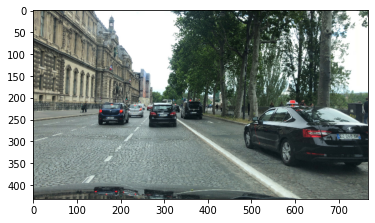

In [6]:
dataset_images = pickle.load(open('/content/drive/My Drive/YOLO/Data/images_tracking.p', "rb"))
###5 Load the Images
#dataset_images = pickle.load(open('Images/images_tracking.p', "rb"))
img =dataset_images[0]
plt.imshow(img)
print(img.shape)

In [7]:
#6visualize it
def visualize_images(input_images):
    fig=plt.figure(figsize=(100,100))

    for i in range(len(input_images)):
        fig.add_subplot(1, len(input_images), i+1)
        plt.imshow(input_images[i])
    plt.show()

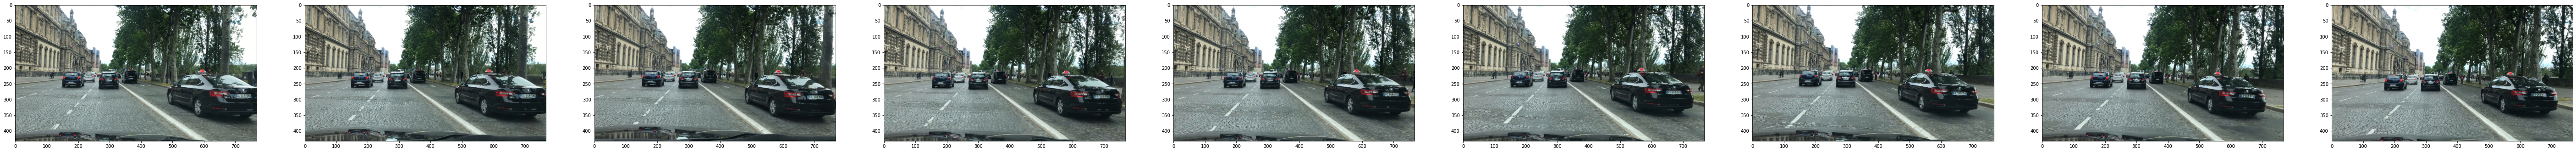

In [8]:
#7
visualize_images(dataset_images)

In [9]:
#8
def convert_data(box):
    """
    Convert data from (x1,y1, w, h) to (x1,y1,x2,y2)
    """
    x1 = box[0]
    x2 = box[0] + box[2]
    y1 = box[1]
    y2 = box[1]+box[3]
    return x1,y1,x2,y2

def box_iou(box1, box2):
    """
    Computer Intersection Over Union cost
    """
    box1 = convert_data(box1)
    box2 = convert_data(box2)
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1) #abs((xi2 - xi1)*(yi2 - yi1))
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) #abs((box1[3] - box1[1])*(box1[2]- box1[0]))
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) #abs((box2[3] - box2[1])*(box2[2]- box2[0]))
    union_area = (box1_area + box2_area) - inter_area
    # compute the IoU
    iou = inter_area/float(union_area)
    return iou

In [10]:
#9 hungarian cost
from math import sqrt, exp

def check_division_by_0(value, epsilon=0.01):
    if value < epsilon:
        value = epsilon
    return value

def hungarian_cost(old_box, new_box, iou_thresh = 0.3, linear_thresh = 10000, exp_thresh = 0.5):
        w1 = 0.5
        w2 = 1.5
        (_, h, w, _) = np.array(dataset_images).shape
        # IOU COST
        iou_cost = box_iou(old_box, new_box)
        
        ### Sanchez-Matilla et al COST
        Q_dist = sqrt(pow(w,2)+pow(h,2)) # First real-life Pythagore use in your life
        Q_shape = w*h
        distance_term = Q_dist/check_division_by_0(sqrt(pow(old_box[0] - new_box[0], 2)+pow(old_box[1] -new_box[1],2)))
        shape_term = Q_shape/check_division_by_0(sqrt(pow(old_box[2] - new_box[2], 2)+pow(old_box[3] - new_box[3],2)))
        linear_cost = distance_term*shape_term

        ## YUL et al COST
        a= (old_box[0] - new_box[0])/check_division_by_0(old_box[2])
        a_2 = pow(a,2)
        b = (old_box[1] - new_box[1])/check_division_by_0(old_box[3])
        b_2 = pow(b,2)
        ab = (a_2+b_2)*w1*(-1)
        c = abs(old_box[3] - new_box[3])/(old_box[3]+new_box[3])
        d = abs(old_box[2]-new_box[2])/(old_box[2]+new_box[2])
        cd = (c+d)*w2*(-1)
        exponential_cost = exp(ab)*exp(cd)

        if (iou_cost >= iou_thresh and linear_cost>=linear_thresh and exponential_cost>=exp_thresh):
            return iou_cost
        else :
            return 0

In [11]:
#10 Data association
from scipy.optimize import linear_sum_assignment

def associate(old_boxes, new_boxes):
    """
    old_boxes will represent the former bounding boxes (at time 0)
    new_boxes will represent the new bounding boxes (at time 1)
    Function goal: Define a Hungarian Matrix with IOU as a metric and return, for each box, an id
    """
    # Define a new IOU Matrix nxm with old and new boxes
    iou_matrix = np.zeros((len(old_boxes),len(new_boxes)),dtype=np.float32)

    # Go through boxes and store the IOU value for each box 
    # You can also use the more challenging cost but still use IOU as a reference for convenience (use as a filter only)
    for i,old_box in enumerate(old_boxes):
        for j,new_box in enumerate(new_boxes):
            iou_matrix[i][j] = box_iou(old_box, new_box)
            #iou_matrix[i][j] = hungarian_cost(old_box, new_box)

    # Call for the Hungarian Algorithm
    hungarian_row, hungarian_col = linear_sum_assignment(-iou_matrix)
    hungarian_matrix = np.array(list(zip(hungarian_row, hungarian_col)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_trackers = [], [], []

    # Go through the Hungarian Matrix, if matched element has IOU < threshold (0.3), add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(iou_matrix[h[0],h[1]]<0.3):
            unmatched_trackers.append(old_boxes[h[0]])
            unmatched_detections.append(new_boxes[h[1]])
        else:
            matches.append(h.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    # Go through old boxes, if no matched detection, add it to the unmatched_old_boxes
    for t,trk in enumerate(old_boxes):
	    if(t not in hungarian_matrix[:,0]):
		    unmatched_trackers.append(trk)
    
    # Go through new boxes, if no matched tracking, add it to the unmatched_new_boxes
    for d, det in enumerate(new_boxes):
        if(d not in hungarian_matrix[:,1]):
                unmatched_detections.append(det)
    
    return matches, unmatched_detections,unmatched_trackers

In [15]:
#11 criterion for Track maintenance
MIN_HIT_STREAK = 2
MAX_UNMATCHED_AGE = 3

In [16]:
#12 store obstacle 
class Obstacle():
    def __init__(self, idx, box, age=1, unmatched_age=0):
        self.idx = idx
        self.box = box
        self.age = age
        self.unmatched_age = unmatched_age

In [17]:
#13 to add color to id
def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*36 %256
    red = idx*23 %256
    return (red, green, blue)

In [18]:
#14 core loop
def main2(input_image):
    """
    Receives an images
    Outputs the result image, and a list of obstacle objects 
    """
    global stored_obstacles # Will be used to keep track of obstacles information
    global idx # Will be used to keep track of id information
    # Run obstacle detection
    image = copy.deepcopy(input_image)
    _, out_boxes = yolo.inference(input_image)
    
    # What we will do will be very similar but we have a second list of obstacles that answer to the conditions
    # On first iteration, we only create obstacles with age=1
    if (idx == 0):
        stored_obstacles = []
        for i, box in enumerate(out_boxes):
            obs = Obstacle(idx, box) # Create an obstacle with age=1
            stored_obstacles.append(obs)                
            idx +=1
        return image
    
    # On this case, if the obstacle has already been matched, we display it depending on the MIN_HIT_STREAK variable
    elif (idx != 0): # In case we already have obstacles from previous frame, work on association
        ## Before calling associate, we must create a list of old obstacles
        old_obstacles = [obs.box for obs in stored_obstacles] # Simply get the boxes
        matches, unmatched_detections, unmatched_tracks = associate(old_obstacles, out_boxes) # Associate the obstacles
        
        selected_obstacles = []
        # Loop through all matches and add these as obstacles
        new_obstacles = []
        for match in matches:
            obs = Obstacle(stored_obstacles[match[0]].idx, out_boxes[match[1]], stored_obstacles[match[0]].age +1) # Increase the age by 1
            new_obstacles.append(obs)
            if obs.age >= MIN_HIT_STREAK:
                selected_obstacles.append(obs)
        
        # Loop through all unmatched detections and add these as obstacles
        for new_obs in unmatched_detections:
            idx +=1
            obs = Obstacle(idx, new_obs)
            new_obstacles.append(obs)
            if obs.age >= MIN_HIT_STREAK:
                selected_obstacles.append(obs)

        for i, old_obs in enumerate(unmatched_tracks):
            if stored_obstacles[i].box == old_obs:
                obs = stored_obstacles[i] 
                obs.unmatched_age +=1
                if obs.unmatched_age <= MAX_UNMATCHED_AGE:
                    selected_obstacles.append(obs)

        # Draw on selected obstacles only
        for i, obs in enumerate(selected_obstacles):
            left, top, right, bottom = convert_data(obs.box)
            cv.rectangle(image, (left, top), (right, bottom), id_to_color(obs.idx), thickness=10)
            image = cv.putText(image, str(obs.idx),(left,top),cv.FONT_HERSHEY_SIMPLEX, 1,id_to_color(obs.idx),thickness=4)                

        stored_obstacles = copy.deepcopy(new_obstacles)
        return image

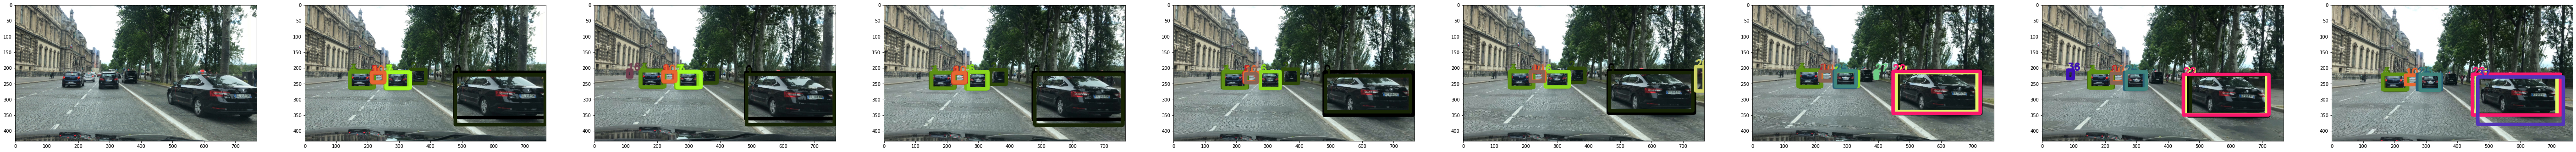

In [19]:
#15 main loop
yolo = YOLO()
idx = 0

fig=plt.figure(figsize=(100,100))

result_images_3 = copy.deepcopy(dataset_images)

out_imgs = []
boxes=[]

for i in range(len(result_images_3)):
    out_img= main2(result_images_3[i])
    #boxes.append(box)
    out_imgs.append(out_img)
    fig.add_subplot(1, len(result_images_3), i+1)
    plt.imshow(out_imgs[i])

plt.show()
#print(boxes[0:100])

In [20]:
#16 now on video
from moviepy.editor import VideoFileClip
idx = 0
detector = YOLO()
video_file = "/content/drive/My Drive/YOLO/Data/paris_challenge.mov" #25 FPS
clip = VideoFileClip(video_file).subclip(0,0.2)
white_clip = clip.fl_image(main2)
%time white_clip.write_videofile("/content/drive/My Drive/YOLO/Data/movie_track_kf_out_2.mp4",audio=False)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1122304/45929032 bytes (2.4%)3694592/45929032 bytes (8.0%)6643712/45929032 bytes (14.5%)9461760/45929032 bytes (20.6%)12361728/45929032 bytes (26.9%)15458304/45929032 bytes (33.7%)18300928/45929032 bytes (39.8%)21110784/45929032 bytes (46.0%)24141824/45929032 bytes (52.6%)27000832/45929032 bytes (58.8%)29868032/45929032 bytes (65.0%)32669696/45929032 bytes (71.1%)357

 92%|█████████▏| 12/13 [00:19<00:01,  1.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/YOLO/Data/movie_track_kf_out_2.mp4 

CPU times: user 30.5 s, sys: 669 ms, total: 31.1 s
Wall time: 26.6 s


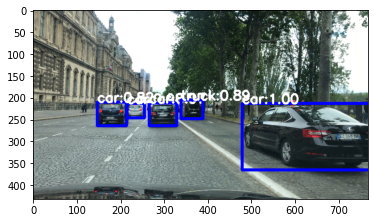

[[479, 213, 776, 365], [215, 213, 255, 246], [266, 212, 329, 264], [339, 205, 389, 248], [147, 210, 214, 264]]


In [ ]:
yolo = YOLO()
oi,boxes1 = yolo.inference(img)
plt.imshow(oi)
plt.show()
print(boxes1)